<a href="https://colab.research.google.com/github/Akash2021/Covid19ArticleSummarizationClustering/blob/main/JupyterNotebooks/LitretureClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['everywhere',
 'somehow',
 'where',
 'nowhere',
 'serious',
 'until',
 'below',
 'without',
 'first',
 'upon']

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)


In [ ]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
# tf.debugging.set_log_device_placement(True)
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/CovidArticles.csv')
df.head()

,paper_id,title,abstract,body_text
0,c79ce955bfc71ffe8159bca6bc81d783a86d8edf,A cross-sectional community-based observationa...,The Asymptomatic novel CORonavirus iNfection (...,The World Health Organization first declared a...
1,97acf17564239fe170cc68c9514daf5909f7d999,Journal Pre-proof Inhaled corticosteroids down...,"Singanayagam A, Inhaled corticosteroids downre...",widely used in COPD but the extent to which th...
2,9e277d3a38ec5bf379b333d675963086ee32e9f2,"KlINISCHE lES Bof, terug van weggeweest",Bof is een ziekte die vroeger bijna alle kinde...,Patiënt A was een volledig tegen bof gevaccine...
3,3cfc7674f189b49a38eacfb52d12f6e3d5d36f98,R E V I E W Coronavirus infections and immune ...,Coronaviruses (CoVs) are by far the largest gr...,The host innate immune system detects viral in...
4,b5bbb2b61abecb00e772bfb00d260939f36f9e6a,International mass gatherings and travel-assoc...,Background: Travelers to international mass ga...,Attendance at an international mass gathering ...


In [ ]:
df=df[:8000]

In [ ]:
from tqdm import tqdm
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 8000/8000 [24:09<00:00,  5.52it/s]


In [ ]:
df.head()

,paper_id,title,abstract,body_text,processed_text
0,c79ce955bfc71ffe8159bca6bc81d783a86d8edf,A cross-sectional community-based observationa...,The Asymptomatic novel CORonavirus iNfection (...,The World Health Organization first declared a...,world health organization ﻿1 declare pandemic ...
1,97acf17564239fe170cc68c9514daf5909f7d999,Journal Pre-proof Inhaled corticosteroids down...,"Singanayagam A, Inhaled corticosteroids downre...",widely used in COPD but the extent to which th...,widely use copd extent therapy protect expose ...
2,9e277d3a38ec5bf379b333d675963086ee32e9f2,"KlINISCHE lES Bof, terug van weggeweest",Bof is een ziekte die vroeger bijna alle kinde...,Patiënt A was een volledig tegen bof gevaccine...,patiënt een volledig tegen bof gevaccineerde 2...
3,3cfc7674f189b49a38eacfb52d12f6e3d5d36f98,R E V I E W Coronavirus infections and immune ...,Coronaviruses (CoVs) are by far the largest gr...,The host innate immune system detects viral in...,host innate immune system detect viral infecti...
4,b5bbb2b61abecb00e772bfb00d260939f36f9e6a,International mass gatherings and travel-assoc...,Background: Travelers to international mass ga...,Attendance at an international mass gathering ...,attendance international mass gather mg expose...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [ ]:
text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(8000, 4096)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(8000, 2339)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

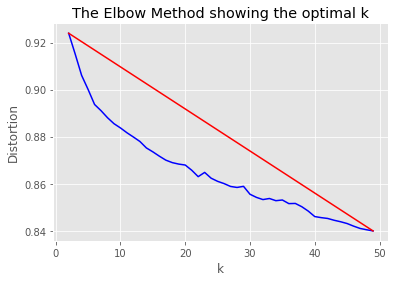

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 8000 samples in 7.659s...
[t-SNE] Computed neighbors for 8000 samples in 681.497s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.370087
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.539673
[t-SNE] KL divergence after 1000 iterations: 2.177233


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


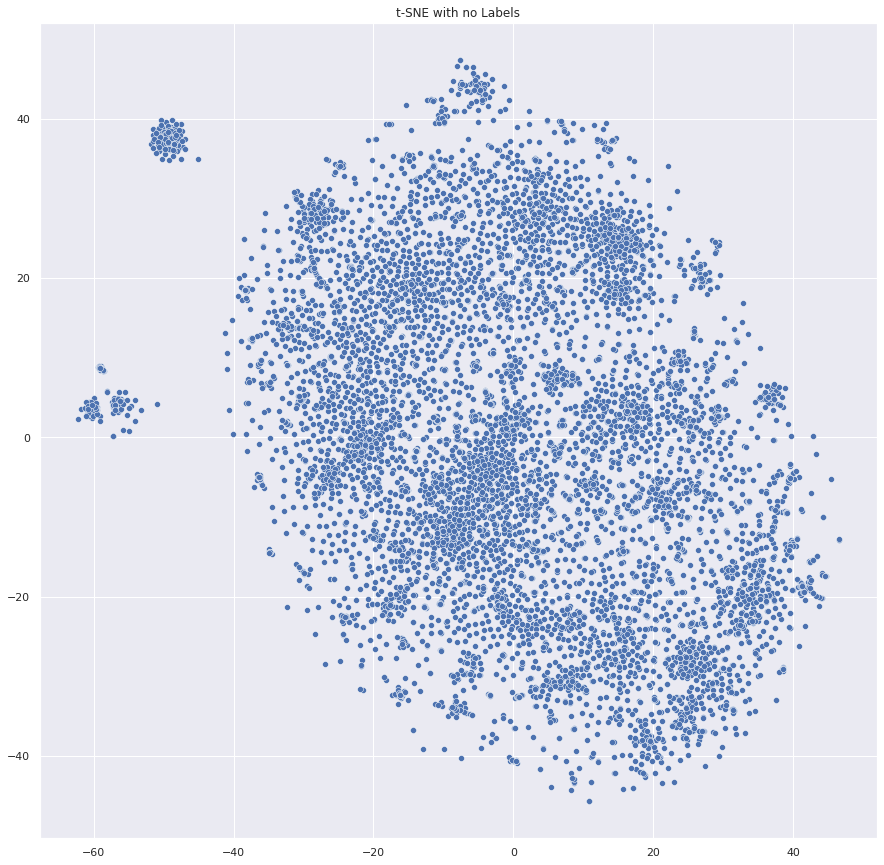

In [ ]:


from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


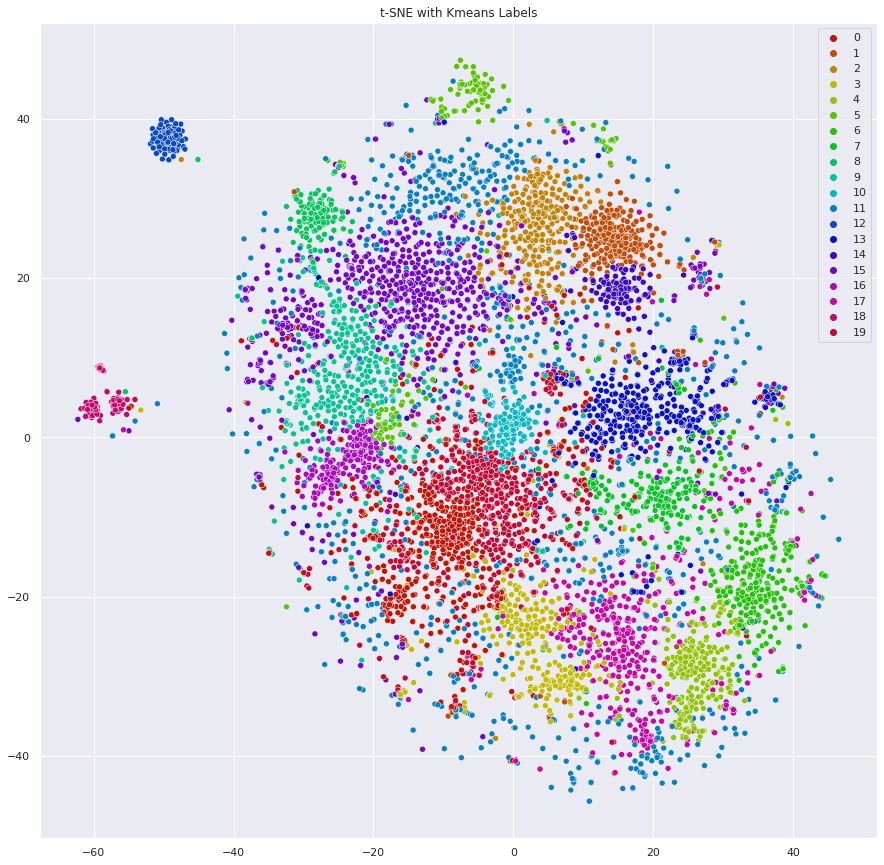

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [ ]:
len(all_keywords)

20

In [ ]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [ ]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [ ]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 6400
X_test size: 1600 



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  88.297 %
     Precision:  90.278 %
        Recall:  89.212 %
      F1 score:  89.663 %


In [ ]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  83.375 %
     Precision:  85.801 %
        Recall:  83.622 %
      F1 score:  84.172 %


In [ ]:
pip install bokeh==1.3.4

     |████████████████████████████████| 17.8MB 203kB/s 
  Created wheel for bokeh: filename=bokeh-1.3.4-cp37-none-any.whl size=8546147 sha256=57f956f9b486ac9be318a77ee00787e13586b82ae8aa71ee64366aaf75c65363
  Stored in directory: /root/.cache/pip/wheels/a7/df/f1/80f108cd241803a5200576ac0eed112f0acea5582575cf08b6
Successfully built bokeh
ERROR: panel 0.11.3 has requirement bokeh<2.4.0,>=2.3.0, but you'll have bokeh 1.3.4 which is incompatible.
  Found existing installation: bokeh 1.4.0
    Uninstalling bokeh-1.4.0:
      Successfully uninstalled bokeh-1.4.0


In [ ]:
# from bokeh.models import CustomJS
from bokeh.models.callbacks import CustomJS
# handle the currently selected article
def selected_code():
    code = """
            var titles = [];
            # var authors = [];
            # var journals = [];
            # var links = [];
            cb_data.source.selected.indices.forEach(index => titles.push(source.data['titles'][index]));
            cb_data.source.selected.indices.forEach(index => authors.push(source.data['authors'][index]));
            cb_data.source.selected.indices.forEach(index => journals.push(source.data['journal'][index]));
            cb_data.source.selected.indices.forEach(index => links.push(source.data['links'][index]));
            title = "<h4>" + titles[0].toString().replace(/<br>/g, ' ') + "</h4>";
            authors = "<p1><b>Authors:</b> " + authors[0].toString().replace(/<br>/g, ' ') + "<br>"
            // journal = "<b>Journal</b>" + journals[0].toString() + "<br>"
            link = "<b>Link:</b> <a href='" + "http://doi.org/" + links[0].toString() + "'>" + "http://doi.org/" + links[0].toString() + "</a></p1>"
            current_selection.text = title + authors + link
            current_selection.change.emit();
    """
    return code

# handle the keywords and search
def input_callback(plot, source, out_text, topics): 

    # slider call back for cluster selection
    callback = CustomJS(args=dict(p=plot, source=source, out_text=out_text, topics=topics), code="""
				var key = text.value;
				key = key.toLowerCase();
				var cluster = slider.value;
                var data = source.data; 
                
                
                x = data['x'];
                y = data['y'];
                x_backup = data['x_backup'];
                y_backup = data['y_backup'];
                labels = data['desc'];
                abstract = data['abstract'];
                titles = data['titles'];
                if (cluster == '20') {
                    out_text.text = 'Keywords: Slide to specific cluster to see the keywords.';
                    for (i = 0; i < x.length; i++) {
						if(abstract[i].includes(key) || 
						titles[i].includes(key) || 
						authors[i].includes(key) || 
						journal[i].includes(key)) {
							x[i] = x_backup[i];
							y[i] = y_backup[i];
						} else {
							x[i] = undefined;
							y[i] = undefined;
						}
                    }
                }
                else {
                    out_text.text = 'Keywords: ' + topics[Number(cluster)];
                    for (i = 0; i < x.length; i++) {
                        if(labels[i] == cluster) {
							if(abstract[i].includes(key) || 
							titles[i].includes(key) || 
							authors[i].includes(key) || 
							journal[i].includes(key)) {
								x[i] = x_backup[i];
								y[i] = y_backup[i];
							} else {
								x[i] = undefined;
								y[i] = undefined;
							}
                        } else {
                            x[i] = undefined;
                            y[i] = undefined;
                        }
                    }
                }
            source.change.emit();
            """)
    return callback

In [ ]:
# required libraries for plot
# from call_backs import input_callback, selected_code  # file with customJS callbacks for bokeh
                                                      # github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/lib/call_backs.py
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [ ]:
import os

topic_path = 'topics.txt'
with open(topic_path) as f:
    topics = f.readlines()

In [ ]:
df.head()

,paper_id,title,abstract,body_text,processed_text,y
0,c79ce955bfc71ffe8159bca6bc81d783a86d8edf,A cross-sectional community-based observationa...,The Asymptomatic novel CORonavirus iNfection (...,The World Health Organization first declared a...,world health organization ﻿1 declare pandemic ...,7
1,97acf17564239fe170cc68c9514daf5909f7d999,Journal Pre-proof Inhaled corticosteroids down...,"Singanayagam A, Inhaled corticosteroids downre...",widely used in COPD but the extent to which th...,widely use copd extent therapy protect expose ...,4
2,9e277d3a38ec5bf379b333d675963086ee32e9f2,"KlINISCHE lES Bof, terug van weggeweest",Bof is een ziekte die vroeger bijna alle kinde...,Patiënt A was een volledig tegen bof gevaccine...,patiënt een volledig tegen bof gevaccineerde 2...,16
3,3cfc7674f189b49a38eacfb52d12f6e3d5d36f98,R E V I E W Coronavirus infections and immune ...,Coronaviruses (CoVs) are by far the largest gr...,The host innate immune system detects viral in...,host innate immune system detect viral infecti...,19
4,b5bbb2b61abecb00e772bfb00d260939f36f9e6a,International mass gatherings and travel-assoc...,Background: Travelers to international mass ga...,Attendance at an international mass gathering ...,attendance international mass gather mg expose...,3


In [ ]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= df['title'],
    # authors = df['authors'],
    # journal = df['journal'],
    abstract = df['abstract'],
    labels = ["C-" + str(x) for x in y_labels],
    # links = df['doi']
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    # ("Author(s)", "@authors{safe}"),
    # ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}")
    # ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

In [ ]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=45)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #",js_event_callbacks =input_callback_1)
keyword = TextInput(title="Search:", callback=input_callback_1)

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

In [ ]:
# STYLE
slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "scale_both"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [ ]:
# LAYOUT OF THE PAGE
l = layout([
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
])
l.sizing_mode = "scale_both"

# show
output_file('t-sne_covid-19_interactive.html')
show(l)